In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from anytree import LevelOrderGroupIter, NodeMixin, PostOrderIter
#from anytree.util import leftsibling
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture

from graspy.cluster import GaussianCluster, AutoGMMCluster
from graspy.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed, selectSVD, select_dimension
#from graspy.models import DCSBMEstimator, RDPGEstimator, SBMEstimator
from graspy.simulations import rdpg
from graspy.utils import augment_diagonal, binarize, pass_to_ranks
from src.data import load_metagraph
from src.graph import preprocess
import warnings

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [107]:
# gmm = GaussianMixture(n_components=2, covariance_type='spherical', random_state=0)
# gmm.fit(np.random.rand(3, 2))
# gmm.means_ = np.array([[0,0],[5,4]])
# gmm.covariances_ = np.array([1,1])
# gmm.weights_ = np.array([0.5,0.5])
# gmm.precisions_cholesky_ = 0
# x1, _ = gmm.sample(50)

# gmm = GaussianMixture(n_components=3, covariance_type='spherical', random_state=4)
# gmm.fit(np.random.rand(3, 2))
# gmm.means_ = np.array([[15,2.5],[21,6],[25,2]])
# gmm.covariances_ = np.array([1,1,1])
# gmm.weights_ = np.array([0.33,0.33,0.33])
# gmm.precisions_cholesky_ = 0
# x2, _ = gmm.sample(70)

# x = np.concatenate([x1, x2])
# fig,ax = plt.subplots(1)
# plt.scatter(x[:,0],x[:,1])
# ax.set(xlabel="First Dimension", ylabel="Second Dimension")

In [2]:
!ln -s /Users/TingshanLiu/Desktop/2020 summer/TL_maggot/notebooks/HSBM.py HSBM.py

usage: ln [-Ffhinsv] source_file [target_file]
       ln [-Ffhinsv] source_file ... target_dir
       link source_file target_file


In [3]:
from HSBM import RecursiveCluster

In [5]:
# rc = RecursiveCluster(X=x, max_components=3)
# labels = rc.fit_predict(x)

In [4]:
# fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,20))
# #fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,3))
# fig1 = sns.scatterplot(x=x[:,0], y=x[:,1],data=labels,hue="lvl1_cum_clusters", legend="full", ax=ax1, palette="deep")
# fig2 = sns.scatterplot(x=x[:,0], y=x[:,1],data=labels,hue="lvl2_cum_clusters", legend="full", ax=ax2, palette="deep")
# fig3 = sns.scatterplot(x=x[:,0], y=x[:,1],data=labels,hue="lvl3_cum_clusters", legend="full", ax=ax3, palette="deep")

# fig1.legend(loc='lower center', bbox_to_anchor=(0.5,-0.5), ncol=1)
# fig2.legend(loc='lower center', bbox_to_anchor=(0.5,-0.5), ncol=1)
# fig3.legend(loc='lower center', bbox_to_anchor=(0.5,-0.5), ncol=1)
# ax3.set(xlabel="First Dimension", title="level3")
# ax2.set(xlabel="First Dimension", title="level2")
# ax1.set(xlabel="First Dimension", ylabel="Second Dimension", title="level1")

#plt.tight_layout()
#plt.savefig('HGMM-synthetic-1')

In [4]:
from graspy.utils import augment_diagonal,binarize,pass_to_ranks,remove_loops,to_laplace
from graspy.cluster import GaussianCluster, KMeansCluster
from graspy.embed import selectSVD
import os
from src.cluster import BinaryCluster
from src.data import load_metagraph
from src.graph import MetaGraph
from src.hierarchy import signal_flow
from src.io import savecsv, savefig
from src.utils import get_paired_inds
from src.hierarchy import signal_flow
from src.visualization import CLASS_COLOR_DICT, plot_single_dendrogram, plot_double_dendrogram, plot_color_labels

os.chdir('/Users/TingshanLiu/Desktop/2020 summer/TL_maggot/maggot_repo')


In [27]:
mg = load_metagraph("G")
class1_types = ["KC", "MBON", "MBIN", "uPN", "mPN", "vPN", "tPN", "APL"]  # no APL
class2_types = []
meta = mg.meta
mb_meta = meta[meta["class1"].isin(class1_types) | meta["class2"].isin(class2_types)]
mb_meta = mb_meta[~mb_meta["partially_differentiated"]]
mb_meta = mb_meta[mb_meta["hemisphere"].isin(["L", "R"])]
mb_mg = mg.reindex(mb_meta.index, use_ids=True, inplace=False)
mb_mg.calculate_degrees(inplace=True)
mb_mg.meta["Total edgesum"] = -mb_mg.meta["Total edgesum"]
sizes = mb_mg.meta.groupby("class1").size()
mb_mg.meta["class1_sizes"] = -mb_mg.meta["class1"].map(sizes)

meta = mb_mg.meta
print("n_left")
print(len(meta[meta["left"]]))
print("n_right")
print(len(meta[meta["right"]]))

n_left
163
n_right
158


In [28]:
meta["class0"] = ''
for i in range(len(meta)):
    if meta["class1"].iloc[i] in ["MBIN", "APL"]:
        meta["class0"].iloc[i] = "MBIN"
    if meta["class1"].iloc[i] in ["MBON"]:
        meta["class0"].iloc[i] = "MBON"
    if meta.iloc[i]["merge_class"].startswith(("KC")):
        meta["class0"].iloc[i] = "KC"
    if meta["class1"].iloc[i] in ["mPN", "tPN", "vPN", "uPN"]:
        meta["class0"].iloc[i] = "PN"


In [29]:
left_mb_mg = mb_mg.reindex(meta[meta["left"]].index, use_ids=True, inplace=False)
right_mb_mg = mb_mg.reindex(meta[meta["right"]].index, use_ids=True, inplace=False)

assert (
    np.unique(left_mb_mg.meta["pair_id"]) == np.unique(right_mb_mg.meta["pair_id"])
).all()

In [30]:
meta = mb_mg.meta
meta["inds"] = range(len(meta))
# left_inds, right_inds = get_paired_inds(meta)
# left_adj = mb_mg.adj[np.ix_(left_inds, left_inds)]
# right_adj = mb_mg.adj[np.ix_(right_inds, right_inds)]

In [31]:
np.random.seed(8888)
side_mgs = {"left": left_mb_mg, "right": right_mb_mg}
side = "left"
side_mb_mg = side_mgs[side]
# labels = side_mb_mg.meta["class1"].values
# labels = mb_mg.meta["class1"].values
# labels = np.vectorize(label_map.get)(labels)

# embed
ase = AdjacencySpectralEmbed(n_components=None)
embed = ase.fit_transform(pass_to_ranks(mb_mg.adj))
# embed = ase.fit_transform(pass_to_ranks(side_mb_mg.adj))
embed = np.concatenate(embed, axis=1)

In [1]:
rc = RecursiveCluster(X=embed, max_components=2)
labels_L_R = rc.fit_predict(embed)

In [33]:
import csv

with open('mg-left-right-bics-max_comp=2.csv', 'w') as f:  # Just use 'w' mode in 3.x
    w = csv.writer(f)
    w.writerows(rc.bics.items())

In [198]:
from pathlib import Path
FNAME = os.path.basename('/Users/TingshanLiu/Desktop/2020 summer/TL_maggot/maggot_repo/maggot_models')

def stashcsv(df, name, **kws):
    savecsv(df, name, foldername=FNAME, **kws)

def _handle_dirs(pathname, foldername, subfoldername):
    path = Path(pathname)
    if foldername is not None:
        path = path / foldername
        if not os.path.isdir(path):
            os.mkdir(path)
        if subfoldername is not None:
            path = path / subfoldername
            if not os.path.isdir(path):
                os.mkdir(path)
    return path

def savecsv(
    df,
    name,
    foldername=None,
    subfoldername="csvs",
    pathname="/Users/TingshanLiu/Desktop/2020 summer/TL_maggot",
    save_on=True,
):
    if save_on:
        path = _handle_dirs(pathname, foldername, subfoldername)
        savename = path / str(name + ".csv")
        df.to_csv(savename)
        print(f"Saved DataFrame to {savename}")

# stashcsv(labels_L_R,"mb-left-right-labels-max_comp=2")

In [10]:
# labels_L = pd.read_csv('/Users/TingshanLiu/Desktop/2020 summer/TL_maggot/maggot_models/csvs/mb-left-labels-max_comp=5.csv')

labels_L_R_max_comp2 = pd.read_csv('/Users/TingshanLiu/Desktop/2020 summer/TL_maggot/maggot_models/csvs/mb-left-right-labels-max_comp=2.csv')

In [11]:
# labels_R = labels_R.astype(str)

labels_L_R_max_comp2 = labels_L_R_max_comp2.astype(str)

In [12]:
n_levels = (labels_L_R_max_comp2.shape[1]-1) // 2
print(n_levels)

for i in range(0,n_levels):
    # side_mb_mg.meta[f"lvl{i}_labels"] = labels_L_max_comp2[f"lvl{i}_labels"].values
    mb_mg.meta[f"lvl{i}_labels"] = labels_L_R_max_comp2[f"lvl{i}_labels"].values

11


In [13]:
lowest_level = n_levels - 1
level_names = [f"lvl{i}_labels" for i in range(lowest_level + 1)]

# mg = side_mb_mg
mg = mb_mg
meta = mg.meta
meta["sf"] = -signal_flow(mg.adj)
class_label = "merge_class"
sort_class = level_names + [class_label]
class_order = ["sf"]
total_sort_by = []
for sc in sort_class:
    for co in class_order:
        class_value = meta.groupby(sc)[co].mean()
        meta[f"{sc}_{co}_order"] = meta[sc].map(class_value)
        total_sort_by.append(f"{sc}_{co}_order")
    total_sort_by.append(sc)
mg = mg.sort_values(total_sort_by, ascending=False)
meta = mg.meta
adj = mg.adj


In [13]:
rc_dict = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.formatter.limits": (-3, 3),
    "figure.figsize": (6, 3),
    "figure.dpi": 100,
    "axes.edgecolor": "lightgrey",
    "ytick.color": "grey",
    "xtick.color": "grey",
    "axes.labelcolor": "dimgrey",
    "text.color": "dimgrey",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
}
for key, val in rc_dict.items():
    mpl.rcParams[key] = val
context = sns.plotting_context(context="talk", font_scale=1.3, rc=rc_dict)
sns.set_context(context)

In [29]:
# check the order of major classes i.e., "class0"

sizes = right_meta.groupby(["class0"], sort=False).size()
uni_class = sizes.index.unique()
uni_class

Index(['MBON', 'MBIN', 'KC', 'PN'], dtype='object', name='class0')

In [30]:
import colorcet as cc

colors_MBON = np.array(cc.glasbey_bw_minc_20)[[7]]
colors_MBIN = np.array(cc.glasbey_bw_minc_20)[[4]]
colors_KC = np.array(cc.glasbey_bw_minc_20)[[82]]
colors_PN = np.array(cc.glasbey_bw_minc_20)[[11]]

# for R hemisphere
colors = [colors_MBON, colors_MBIN, colors_KC, colors_PN]

# for L hemisphere
# colors = [colors_MBON, colors_MBIN, colors_PN, colors_KC]

In [31]:
# retrieve colors from cc.glasbey in the order of colors; 
# diff desat so classes in colors[i] have sightly diff colors 

pal = sns.color_palette(palette=colors[0], n_colors=len(colors[0]))
# for R hemisphere:
colors_length = [4,4,7,5] # MBON(4) + MBIN(4) + KC(7) + PN(5)

# for L hemisphere:
# colors_length = [4,4,5,7] # MBON(4)/ + MBIN(4) + PN(5) + KC(7)
for j in range(len(colors)):
    desats = np.array([1,.9,.8,.7,.6,.5,.4])
    desats = desats[:colors_length[j]]
    for i in range(len(desats)):
        pal_new = sns.color_palette(palette=colors[j], n_colors=len(colors[j]), desat=desats[i])
        pal = np.concatenate([pal,pal_new], axis=0)
pal = pal[1:]
pal

array([[1.        , 0.647059  , 0.188235  ],
       [0.95941175, 0.64176485, 0.22882325],
       [0.9188235 , 0.6364707 , 0.2694115 ],
       [0.87823525, 0.63117655, 0.30999975],
       [0.596078  , 1.        , 0.        ],
       [0.5864702 , 0.95      , 0.05      ],
       [0.5768624 , 0.9       , 0.1       ],
       [0.5672546 , 0.85      , 0.15      ],
       [1.        , 0.109804  , 0.270588  ],
       [0.9554902 , 0.1543138 , 0.2990194 ],
       [0.9109804 , 0.1988236 , 0.3274508 ],
       [0.8664706 , 0.2433334 , 0.3558822 ],
       [0.8219608 , 0.2878432 , 0.3843136 ],
       [0.777451  , 0.332353  , 0.412745  ],
       [0.7329412 , 0.3768628 , 0.4411764 ],
       [0.        , 0.992157  , 0.811765  ],
       [0.04960785, 0.94254915, 0.78019635],
       [0.0992157 , 0.8929413 , 0.7486277 ],
       [0.14882355, 0.84333345, 0.71705905],
       [0.1984314 , 0.7937256 , 0.6854904 ]])

In [32]:
# reorder pal to match the ordering of classes in uni_class

sizes = left_meta.groupby([class_label], sort=False).size()
uni_class = sizes.index.unique()
uni_class

# major_classes = ["ON", "IN", "PN", "KC"] # for L-hemisphere 
major_classes = ["ON", "IN", "KC", "PN"] # for R-hemisphere

pal_new = pal[0].reshape(1,3)
for j in range(len(major_classes)):
    if major_classes[j] == "IN":
        inds = [i for i, s in enumerate(list(uni_class)) if any(x in s for x in ["IN","APL"])]
    else:
        inds = [i for i, s in enumerate(list(uni_class)) if major_classes[j] in s]
    pal_new = np.concatenate([pal_new, pal[inds]], axis=0)
pal_new = pal_new[1:]

len(pal_new)

20

In [33]:
sizes = left_meta.groupby([class_label], sort=False).size()
uni_class = sizes.index.unique()
counts = sizes.values
count_map = dict(zip(uni_class, counts))
count_map

{'MBON-av': 6,
 'MBIN': 5,
 'MBIN-DAN': 7,
 'MBIN-OAN': 2,
 'uPN': 21,
 'mPN-olfac': 6,
 'KC': 6,
 'KC-6claw': 4,
 'KC-3claw': 16,
 'KC-5claw': 7,
 'KC-4claw': 19,
 'KC-2claw': 10,
 'KC-1claw': 17,
 'MBON-app': 8,
 'MBON': 6,
 'MBON-neith': 4,
 'APL': 1,
 'mPN-multi': 8,
 'vPN': 5,
 'tPN': 5}

In [19]:
# [color_map.get(heights.index[n]) for n in range(len(heights))]

In [34]:
# reorder count_map so that classes in the same "class0" are together for making color_label

# major_classes = ["ON", "IN", "PN", "KC"] # for L-hemisphere
major_classes = ["ON", "IN", "KC", "PN"] # for R-hemisphere

count_map_new = {}
for i in range(len(major_classes)):   
    major_class = major_classes[i]
    if major_class == "IN":
        major_class = [major_class, "APL"]
        a = {k:v for (k,v) in count_map.items() if any(x in k for x in major_class)}
    else:
        a = {k:v for (k,v) in count_map.items() if major_class in k}
    count_map_new.update(a)
count_map = count_map_new
count_map

{'MBON-av': 6,
 'MBON-app': 8,
 'MBON': 6,
 'MBON-neith': 4,
 'MBIN': 5,
 'MBIN-DAN': 7,
 'MBIN-OAN': 2,
 'APL': 1,
 'KC': 6,
 'KC-6claw': 4,
 'KC-3claw': 16,
 'KC-5claw': 7,
 'KC-4claw': 19,
 'KC-2claw': 10,
 'KC-1claw': 17,
 'uPN': 21,
 'mPN-olfac': 6,
 'mPN-multi': 8,
 'vPN': 5,
 'tPN': 5}

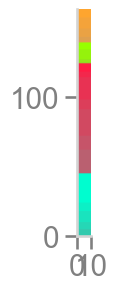

In [35]:
# check color_label

pal_single = pal[0].reshape((1,1,3))
pal_single = np.repeat(pal_single, list(count_map.values())[0], axis = 0)
pals = pal_single
for i in range(1,len(pal)):
    pal_single = pal[i].reshape((1,1,3))
    pal_single = np.repeat(pal_single, list(count_map.values())[i], axis = 0)
    pals = np.concatenate((pals, pal_single), axis = 0)
pals = pals.reshape(len(pals),1,3)

plt.imshow(pals, extent=(0,10,0,len(pals)))


In [22]:
def palplot(xmin,xmax,ymin,ymax,
    pal, count_map, cmap="viridis", figsize=(1, 10), ax=None, start=0, stop=None):
    # if isinstance(k, int):
    #     pal = sns.color_palette(palette=cmap, n_colors=k)
    # else:
    #     pal = k
    k = len(pal)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    # pal = np.array(pal)
    # pal = pal.reshape((k, 1, 3))

    pal_single = pal[0].reshape((1,1,3))
    pal_single = np.repeat(pal_single, list(count_map.values())[0], axis = 0)
    pals = pal_single
    for i in range(1,len(pal)):
        pal_single = pal[i].reshape((1,1,3))
        pal_single = np.repeat(pal_single, list(count_map.values())[i], axis = 0)
        pals = np.concatenate((pals, pal_single), axis = 0)
    pals = pals.reshape(len(pals),1,3)[::-1]
    ax.imshow(pals, extent=(xmin,xmax,ymin,ymax))

In [23]:
def plot_color_labels1(meta, ax, xmin, xmax, ymin, ymax, xleft, pal, count_map):
    palplot(xmin,xmax,ymin,ymax,pal, count_map, ax=ax)
    #ax.yaxis.set_major_formatter(plt.FixedFormatter(names))

    sizes = meta.groupby(["class0"], sort=False).size()
    uni_class = sizes.index.unique()
    counts = sizes.values
    count_map = dict(zip(uni_class, counts))
    names = []
    for key, val in count_map.items():
        names.append(f"{key} ({count_map[key]})")
    names = names[::-1]  # reverse because of signal flow sorting
    counts = counts[::-1]

    offsets = np.concatenate([np.zeros(1),np.cumsum(counts)])[:-1]
    slice_length = (ymax-ymin) / len(meta)
    offsets = slice_length * offsets
    # ax.axis("off")
    for i in range(len(counts)):
        ax.annotate(names[i], xy=(xleft, ymax - offsets[i] - slice_length * counts[i]/2), xycoords='data')

In [ ]:
#make the single dendrogram figure

sizes = meta.groupby([class_label], sort=False).size()
uni_class = sizes.index.unique()
counts = sizes.values
color_map = dict(zip(uni_class, pal_new))

# lowest_level = 7
width_ratios = [0.4,0.2]

#for l in range(lowest_level + 1):
l = n_levels - 1
fig, axs = plt.subplots(
    1, 2, figsize=(13, 50), gridspec_kw=dict(width_ratios=width_ratios)
)

first_mid_map, maximum_for_labels, heights_for_labels = plot_single_dendrogram(meta, axs[0], class_label, color_map, draw_labels=True, lowest_level=l)

xmin = 0.9; xmax = 2; ymin = 0; ymax = len(meta); xleft = 2.1
ymin = -20; ymax = 20
plot_color_labels1(meta, axs[2], xmin, xmax, ymin, ymax, xleft, pal, count_map)

# axs[0].set_xlim(-1.5,l+0.5)
axs[1].set_xlim(0,3)
# xleft = -0.5
# heights_for_labels = heights_for_labels[::-1]
# for i in range(len(heights_for_labels)):
#     if i == 0:
#         offset = 0
#     else:
#         offset += heights_for_labels[i-1]
#     axs[0].annotate(names[i], xy=(xleft, maximum_for_labels - offset - heights_for_labels[i]/2), xycoords='data', ha="right")
axs[1].axis("off")
# mpl.rcParams.update({'font.size': 10})
plt.tight_layout()
# plt.savefig("3")

In [ ]:
# compare to MaggotCluster

In [32]:
n_levels = 11  # max # of splits in the recursive clustering
metric = "bic"  # metric on which to decide best split
bic_ratio = 1  # ratio used for whether or not to split
# meta = side_mb_mg.meta
meta = mb_mg.meta

ase = AdjacencySpectralEmbed(n_components=None)
embed = ase.fit_transform(pass_to_ranks(mb_mg.adj))
embed = np.concatenate(embed, axis=1)

In [2]:
np.random.seed(8888)
mc = BinaryCluster(
    "0",
    adj=mb_mg.adj,  # stored for plotting, basically
    n_init=50,  # number of initializations for GMM at each stage
    meta=meta,  # stored for plotting, basically
    X=embed,  # input data that actually matters
    bic_ratio=bic_ratio,
    reembed=False,
    min_split=1,
)

mc.fit(n_levels=n_levels, metric=metric)

In [101]:
import csv

with open('mg-left-right-bics-max_comp=2-MC-n_init=50.csv', 'w') as f:  # Just use 'w' mode in 3.x
    w = csv.writer(f)
    w.writerows(mc.bics.items())

In [106]:
bics_mc_50inits.loc[-1] = bics_mc_50inits.columns.copy()  # adding a row
bics_mc_50inits.index = bics_mc_50inits.index + 1  # shifting index
bics_mc_50inits = bics_mc_50inits.sort_index()  # sorting by index
bics_mc_50inits.columns = ["level", "bics"]
bics_mc_50inits

,level,bics
0,level0,[4953.14774447873]
1,level1,"[3245.2168589924518, 5034.0847611799545]"
2,level2,"[554.545301236771, 5463.204927614887]"
3,level3,"[389.31329515237167, 4049.513876903937]"
4,level4,"[462.9394049988345, 326.1844919978405, 2146.23..."
5,level5,"[311.31629912852003, 319.8078655800003, 291.47..."
6,level6,"[286.76001501642315, 1341.0702190017678, 349.0..."
7,level7,"[967.6215030255594, 323.3612273140722]"
8,level8,"[458.47997189677903, 642.2666449267524]"
9,level9,"[455.6030399643048, 642.2666449267524]"


In [87]:
bics_all_algo = pd.DataFrame(np.array([0,5446.3401552758105,4953.14774447873,4953.14774447873]).reshape(1,4))
bics_all_algo.columns = ["level", "HGMM", "MaggotCluster-n_init=1", "MaggotCluster-n_init=50"]

In [195]:
bics_all_algo = bics_all_algo.melt(id_vars=['Level'], value_vars=['HGMM', 'MaggotCluster-n_init=1', 'MaggotCluster-n_init=50'])
bics_mean = pd.DataFrame(np.random.rand(33,3))
bics_mean.columns = ["Level", "Algorithm", "Mean BIC"]
for i in range(len(bics_all_algo)):
    bics_mean["Mean BIC"].iloc[i] = np.mean(bics_all_algo["value"].iloc[i])
    bics_mean["Algorithm"].iloc[i] = bics_all_algo["variable"].iloc[i]
    bics_mean["Level"].iloc[i] = bics_all_algo["Level"].iloc[i]
bics_mean

,Level,Algorithm,Mean BIC
0,0.0,HGMM,5446.340155
1,1.0,HGMM,4432.024109
2,2.0,HGMM,2722.536975
3,3.0,HGMM,1576.495333
4,4.0,HGMM,985.632723
5,5.0,HGMM,777.691036
6,6.0,HGMM,481.890632
7,7.0,HGMM,320.368754
8,8.0,HGMM,234.763696
9,9.0,HGMM,243.815221


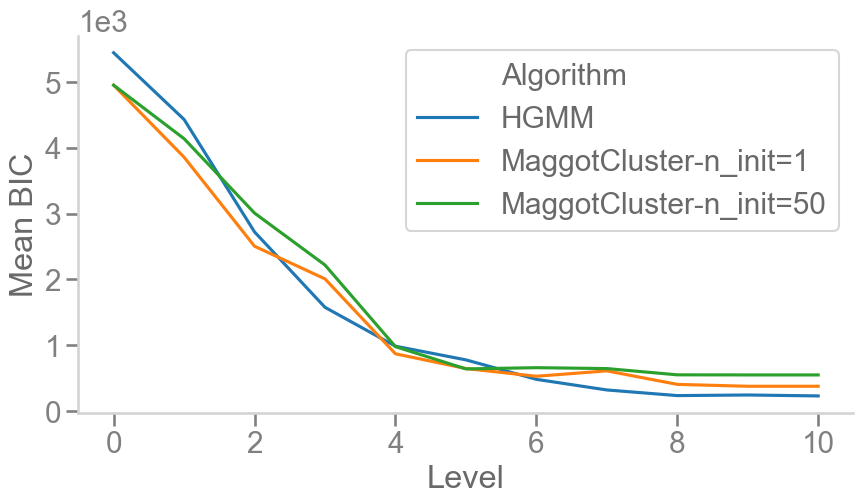

In [196]:
fig,ax = plt.subplots(1, figsize=(10,5))
sns.lineplot(data=bics_mean, x="Level", y="Mean BIC", hue="Algorithm")

In [12]:
# lowest_level = n_levels-1
lowest_level = 9
level_names = [f"lvl{i}_labels" for i in range(lowest_level + 1)]

meta = mc.meta
meta["sf"] = -signal_flow(mb_mg.adj)
class_label = "merge_class"
sort_class = level_names + [class_label]
class_order = ["sf"]
total_sort_by = []
for sc in sort_class:
    for co in class_order:
        class_value = meta.groupby(sc)[co].mean()
        meta[f"{sc}_{co}_order"] = meta[sc].map(class_value)
        total_sort_by.append(f"{sc}_{co}_order")
    total_sort_by.append(sc)

# lp_inds, rp_inds = get_paired_inds(meta)
# inds = np.concatenate((lp_inds, rp_inds))
# adj = mb_mg.adj
# adj = adj[np.ix_(inds, inds)]
# mg = MetaGraph(adj, meta)
meta = meta.sort_values(total_sort_by, ascending=False)
# meta_mc = meta

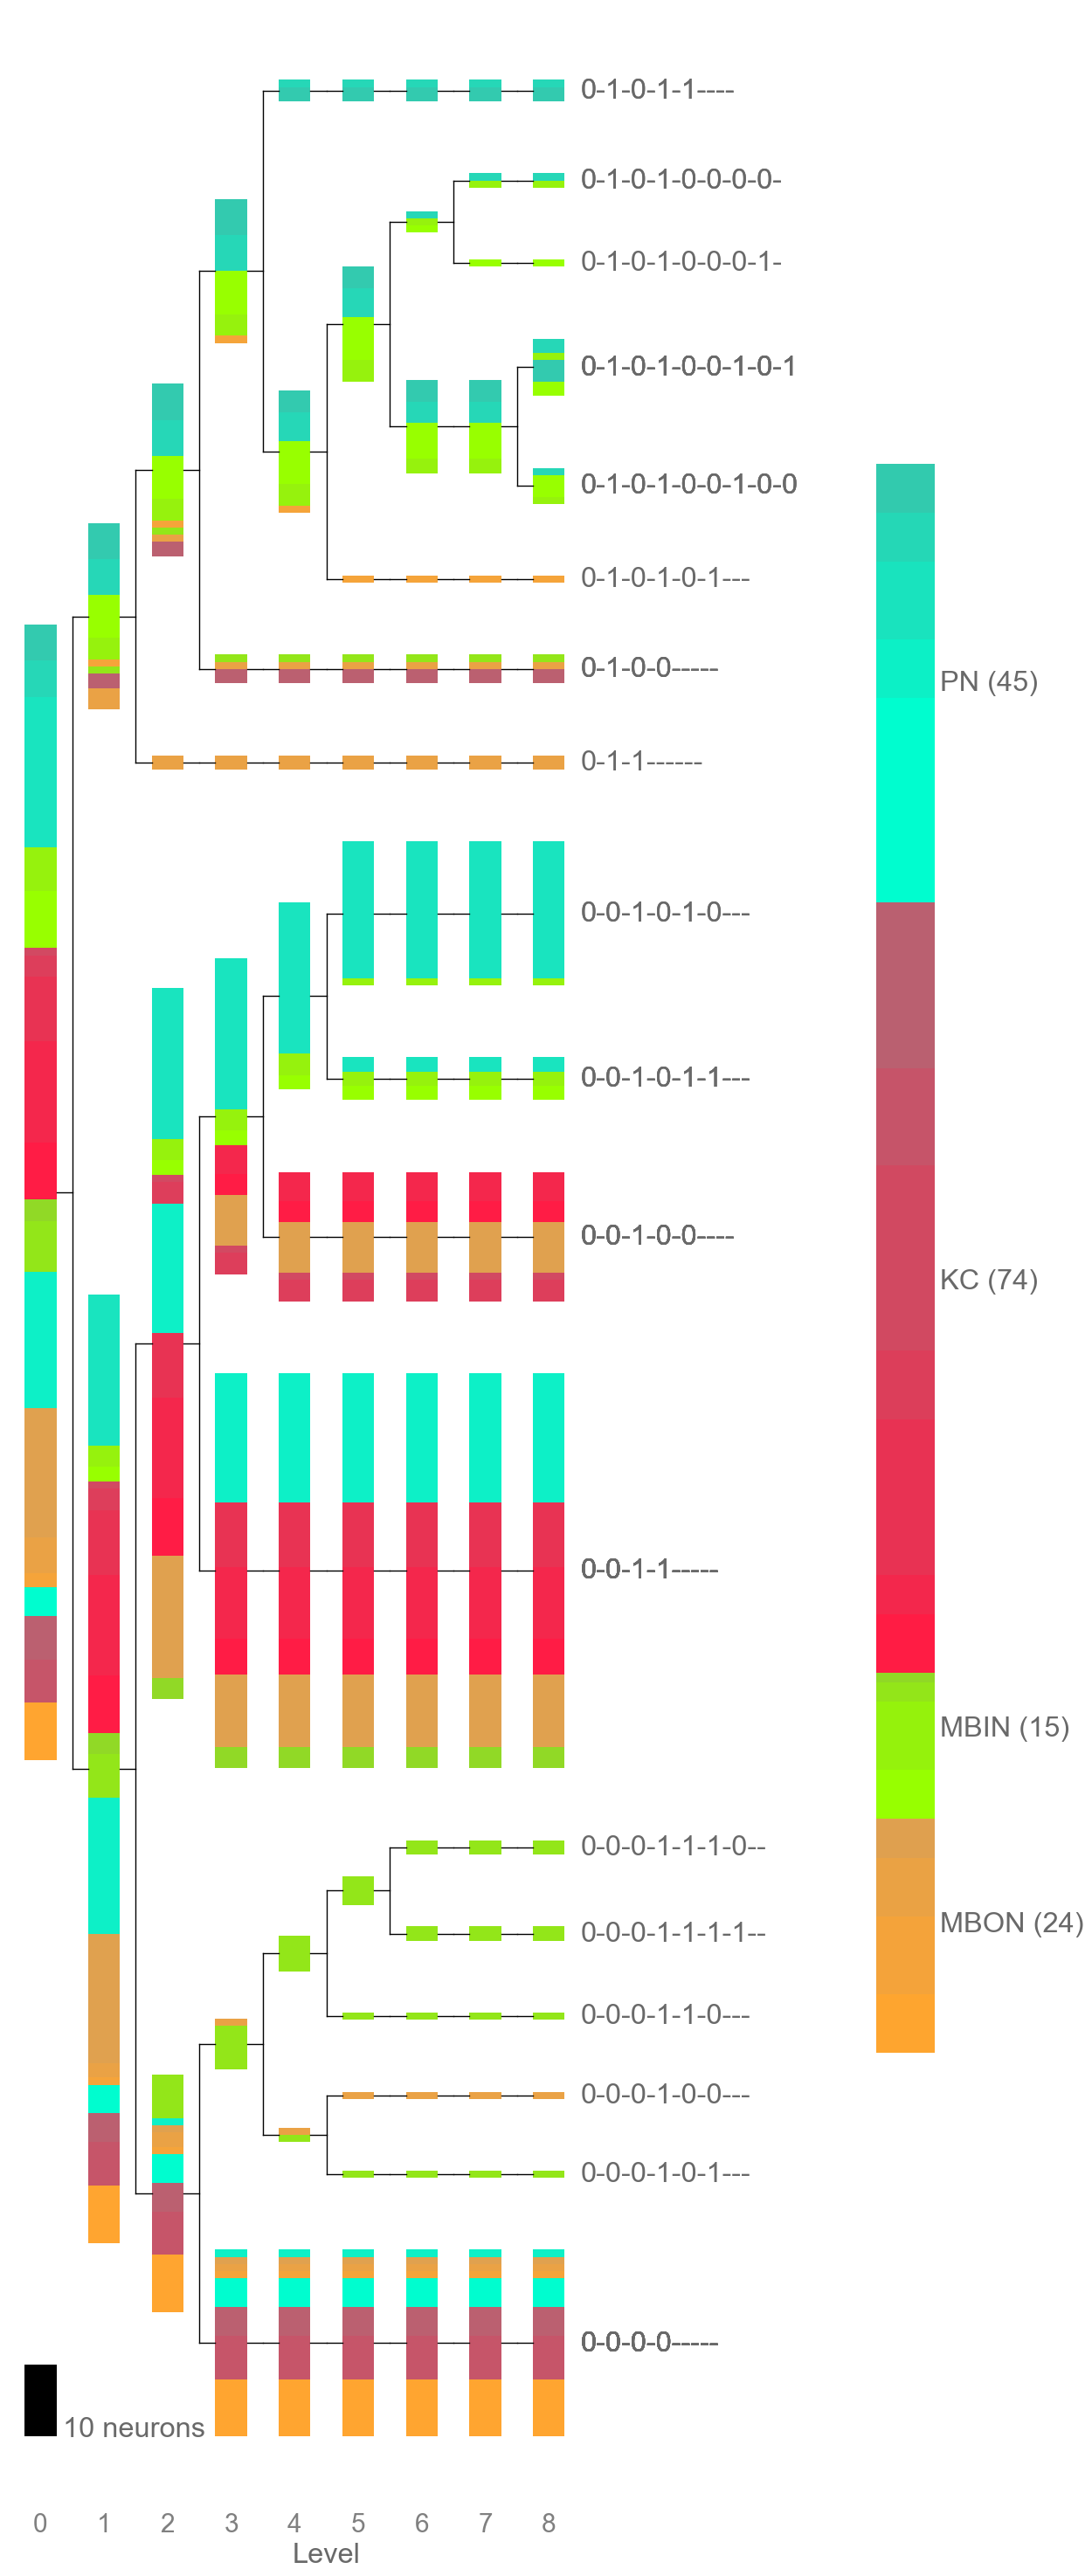

In [37]:
sizes = right_meta.groupby([class_label], sort=False).size()
uni_class = sizes.index.unique()
counts = sizes.values
color_map = dict(zip(uni_class, pal_new))

l = 8
width_ratios=[0.8,0.2]
fig, axs = plt.subplots(
    1, 2, figsize=(13, 30), gridspec_kw=dict(width_ratios=width_ratios)
)
first_mid_map, maximum_for_labels, heights_for_labels = plot_single_dendrogram(right_meta, axs[0], class_label, color_map, draw_labels=True, lowest_level=l)
xmin = 0.9; xmax = 2; ymin = 0; ymax = len(meta); xleft = 2.1
ymin = -15; ymax = 15
plot_color_labels1(right_meta, axs[1], xmin, xmax, ymin, ymax, xleft, pal, count_map)

axs[1].set_xlim(0,3)
axs[1].axis("off")
plt.tight_layout()
plt.savefig("3")